In [1]:
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import scipy.stats as stats
import seaborn as sns
import ast
from scipy.stats import ttest_ind, levene, shapiro, mannwhitneyu, ttest_1samp
from statsmodels.stats.proportion import binom_test

In [2]:
print(os.getcwd())
os.chdir("../..")
print(os.getcwd())
folder_path = '/project/3024020.02/data/extracted_20250301/raw'

/home/control/yimzha/Documents/RLWM/Analysis
/home/control/yimzha/Documents


In [3]:
plt.rcParams.update({
    'font.size': 10,
    'axes.labelsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'figure.dpi': 300,
    'legend.fontsize': 10,
    'legend.loc': 'lower right',
    'legend.frameon': False,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.width': 0.5,
    'ytick.major.width': 0.5,
})

### Learning stage - behav

/scratch/yimzha/slurm_job_47642267/ipykernel_927989/3829881813.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_under['group'] = 'PD Under'
/scratch/yimzha/slurm_job_47642267/ipykernel_927989/3829881813.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_moderate['group'] = 'PD OK'


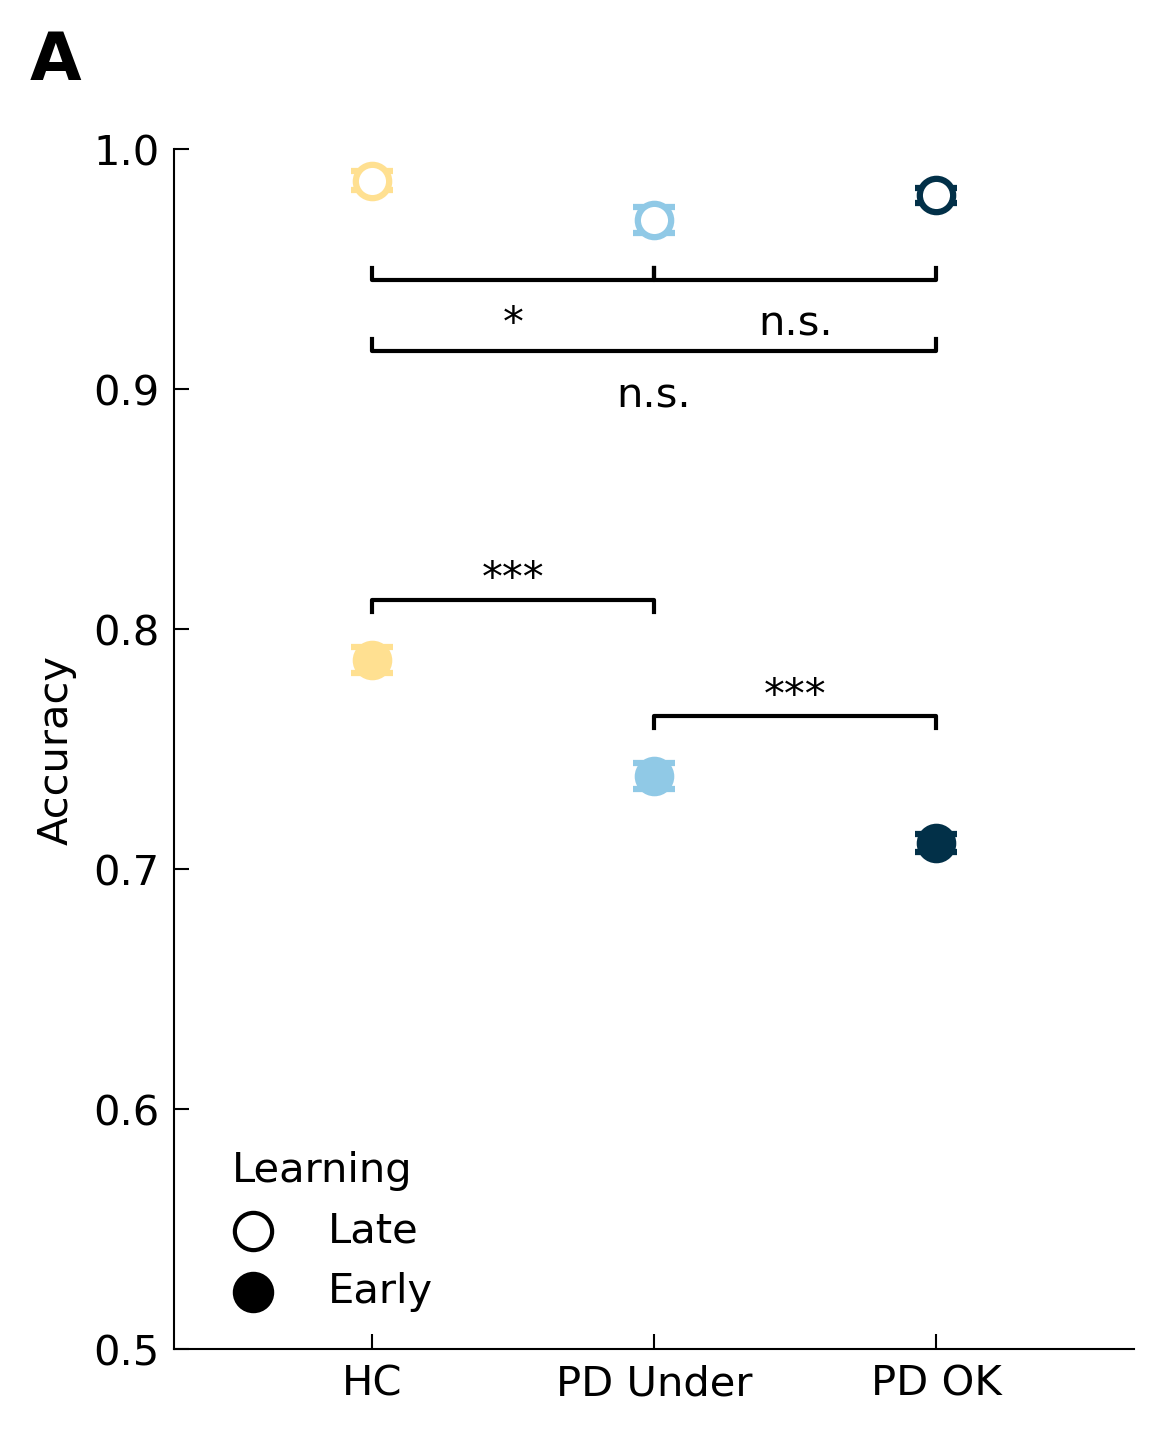

In [68]:
df_pd = pd.read_csv('clean_pd_mds_med.csv')
df_hc = pd.read_csv('clean_hc.csv')
df_pd = df_pd[(df_pd['learning'] != -1)]
df_hc = df_hc[(df_hc['learning'] != -1)]

df_under = df_pd[df_pd['med_motor_PAL'] < 2]
df_moderate = df_pd[df_pd['med_motor_PAL'] >= 2]

df_hc['group'] = 'HC'
df_under['group'] = 'PD Under'
df_moderate['group'] = 'PD OK'
df_all = pd.concat([df_hc, df_under, df_moderate], ignore_index=True)
df_all = df_all[['group', 'learning', 'correct']]

summary = df_all.groupby(['group', 'learning'])['correct'].agg(['mean', 'sem']).reset_index()

# 更新 group_order 顺序
group_order = ['HC', 'PD Under', 'PD OK']
group_colors = {
    'HC': '#ffe091',
    'PD Under': '#90c9e6',
    'PD OK': '#023048'
}

# 横坐标整体右移
x_pos = np.arange(len(group_order))
learning_labels = {0: 'Early', 1: 'Late'}

fig, ax = plt.subplots(figsize=(4, 5))

# 画点：early 和 late 都画在相同位置
for i, learning_level in enumerate([0, 1]):
    for j, group in enumerate(group_order):
        row = summary[(summary['group'] == group) & (summary['learning'] == learning_level)]
        if not row.empty:
            mean = row['mean'].values[0]
            sem = row['sem'].values[0]

            facecolor = group_colors[group] if learning_level == 0 else 'white'
            edgecolor = group_colors[group]

            ax.errorbar(x_pos[j], mean, yerr=sem,
                        fmt='o',
                        markersize=8, capsize=5,markeredgewidth=1.5,
                        markerfacecolor=facecolor,
                        markeredgecolor=edgecolor,
                        ecolor=edgecolor, color=edgecolor,
                        elinewidth=2)

# 设置图例
for learning_level in [1, 0]:
    ax.scatter([], [], 
               color="black" if learning_level == 0 else 'white',
               edgecolor='black',
               marker='o', label=learning_labels[learning_level], s=80)

ax.set_xticks(x_pos)
ax.set_xticklabels(group_order)
ax.set_ylabel('Accuracy')
plt.ylim(0.5, 1.0)
plt.yticks(np.arange(0.5, 1.01, 0.1))
ax.set_xlim(min(x_pos) - 0.7, max(x_pos) + 0.7)
legend = ax.legend(title='Learning', loc='lower left')
legend.get_title().set_fontsize(10)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['left'].set_linewidth(0.5)

# 显著性检测 & 标星号
comparisons = [('HC', 'PD Under'), ('PD Under', 'PD OK'), ('HC', 'PD OK')]

for i, learning_level in enumerate([0, 1]):
    for k, (g1, g2) in enumerate(comparisons):
        group1_data = df_all[(df_all['group'] == g1) & (df_all['learning'] == learning_level)]['correct']
        group2_data = df_all[(df_all['group'] == g2) & (df_all['learning'] == learning_level)]['correct']
        t_stat, p_val = ttest_ind(group1_data, group2_data, equal_var=False)

        # 画横线与星号
        if p_val < 0.001:
            stars = '***'
        elif p_val < 0.01:
            stars = '**'
        elif p_val < 0.05:
            stars = '*'
        else:
            stars = 'n.s.'

        x1, x2 = x_pos[group_order.index(g1)], x_pos[group_order.index(g2)]
        y_base = max(
            summary[(summary['group'] == g1) & (summary['learning'] == learning_level)]['mean'].values[0],
            summary[(summary['group'] == g2) & (summary['learning'] == learning_level)]['mean'].values[0]
        )

        if (learning_level == 0) & (k != 2):
            # Early
            y = y_base + 0.02
            ax.plot([x1, x1, x2, x2], [y, y + 0.005, y + 0.005, y], color='black', linewidth=1)
            ax.text((x1 + x2) / 2, y + 0.005, stars, ha='center', va='bottom', fontsize=10)
        elif (learning_level == 1) & (k != 2):
            # Late
            y_base = min(
                summary[(summary['group'] == g1) & (summary['learning'] == learning_level)]['mean'].values[0],
                summary[(summary['group'] == g2) & (summary['learning'] == learning_level)]['mean'].values[0]
            )
            y = y_base - 0.02
            ax.plot([x1, x1, x2, x2], [y, y - 0.005, y - 0.005, y], color='black', linewidth=1)
            ax.text((x1 + x2) / 2, y - 0.015, stars, ha='center', va='top', fontsize=10)
        elif (learning_level == 1) & (k == 2):
            # Late
            y_base = min(
                summary[(summary['group'] == g1) & (summary['learning'] == learning_level)]['mean'].values[0],
                summary[(summary['group'] == g2) & (summary['learning'] == learning_level)]['mean'].values[0]
            )
            y = y_base - 0.06
            ax.plot([x1, x1, x2, x2], [y, y - 0.005, y - 0.005, y], color='black', linewidth=1)
            ax.text((x1 + x2) / 2, y - 0.015, stars, ha='center', va='top', fontsize=10)

plt.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.15)
plt.text(-0.15, 1.1, 'A', transform=plt.gca().transAxes,
         fontsize=16, fontweight='bold', va='top', ha='left')
plt.show()

/scratch/yimzha/slurm_job_47642267/ipykernel_927989/3064186684.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['delay_grp'] = np.where(df['delay'] >= 7, '7+', df['delay'].astype(str))
/scratch/yimzha/slurm_job_47642267/ipykernel_927989/3064186684.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['delay_grp'] = np.where(df['delay'] >= 7, '7+', df['delay'].astype(str))


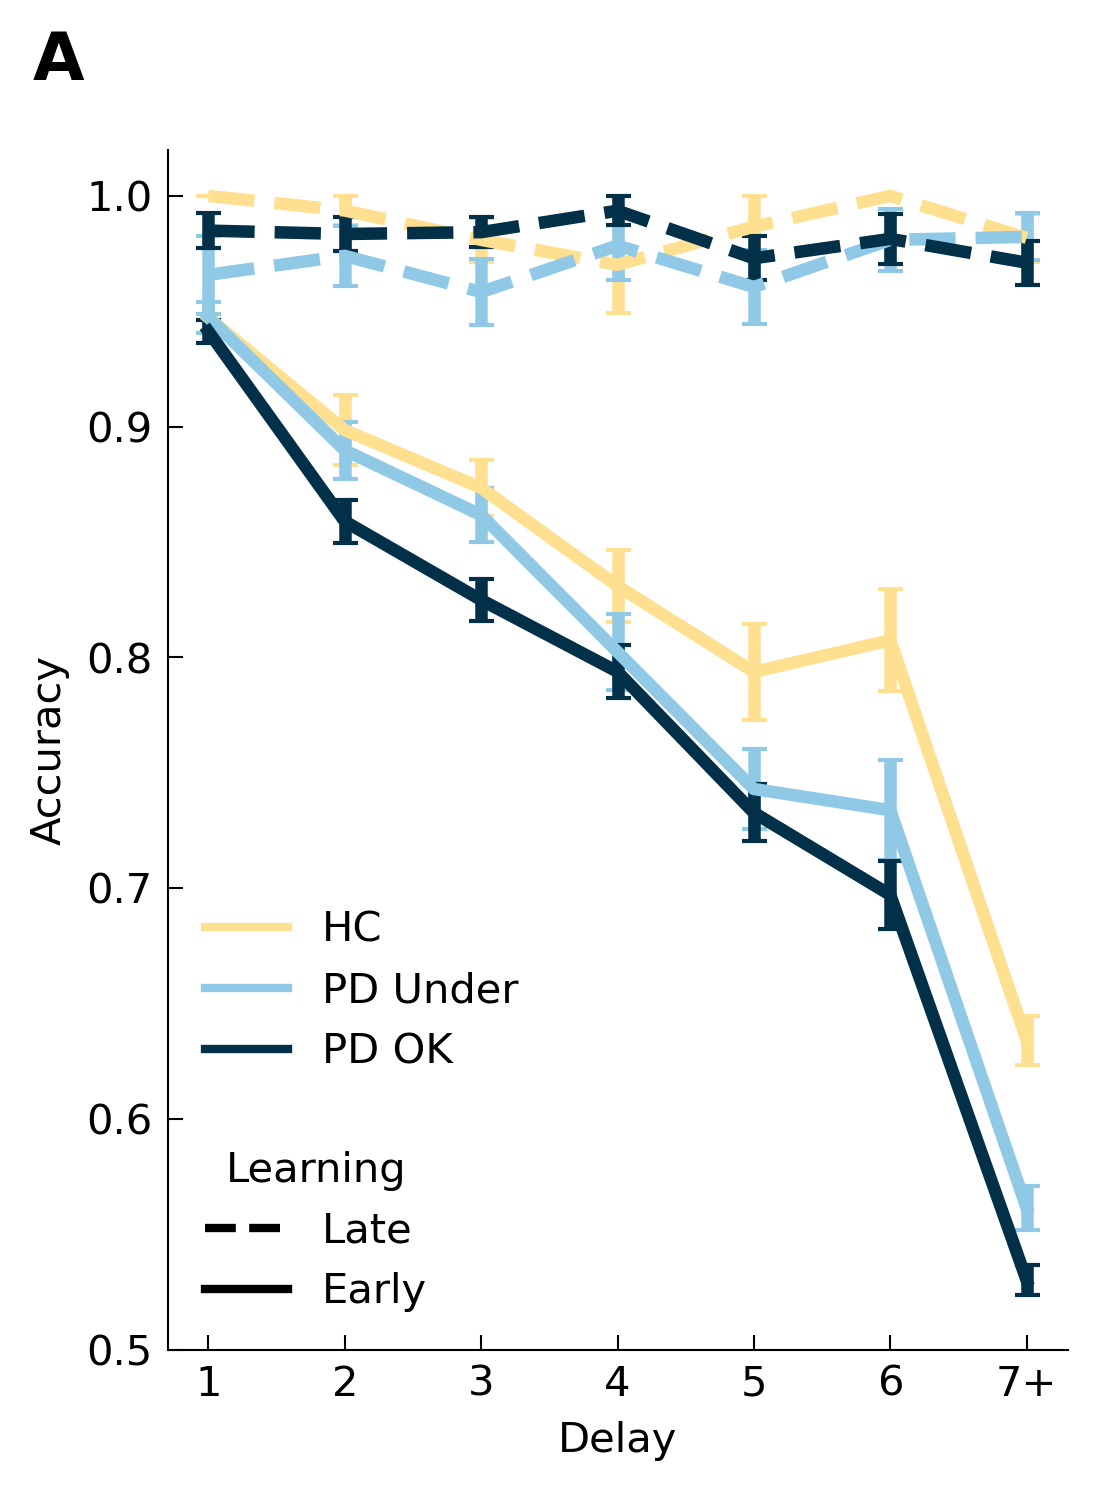

In [70]:
df_pd = pd.read_csv('clean_pd_mds_med.csv')
df_hc = pd.read_csv('clean_hc.csv')

# 过滤无效数据
df_pd = df_pd[(df_pd['delay'] != -1) & (df_pd['learning'] != -1)]
df_hc = df_hc[(df_hc['delay'] != -1) & (df_hc['learning'] != -1)]

# 子组划分
df_under = df_pd[df_pd['med_motor_PAL'] < 2]
df_moderate = df_pd[df_pd['med_motor_PAL'] >= 2]

# 创建 delay 分组列
for df in [df_hc, df_under, df_moderate]:
    df['delay_grp'] = np.where(df['delay'] >= 7, '7+', df['delay'].astype(str))

# 聚合函数
def compute_group(df):
    grouped = df.groupby(['learning', 'delay_grp'])['correct'].agg(['mean', 'sem']).reset_index()
    grouped['delay_grp'] = pd.Categorical(grouped['delay_grp'], categories=['1', '2', '3', '4', '5', '6', '7+'], ordered=True)
    return grouped.sort_values(by='delay_grp')

# 聚合数据
grouped_hc = compute_group(df_hc)
grouped_under = compute_group(df_under)
grouped_moderate = compute_group(df_moderate)

# 配置颜色和线型
labels = {0: 'Early', 1: 'Late'}
linestyles = {0: '-', 1: '--'}
group_data = {
    'HC': (grouped_hc, '#ffe091'),
    'PD Under': (grouped_under, '#90c9e6'),
    'PD OK': (grouped_moderate, '#023048')
}

# 绘图
fig, ax = plt.subplots(figsize=(4, 5))

for group_name, (group_df, color) in group_data.items():
    for learning_val in [0, 1]:
        subset = group_df[group_df['learning'] == learning_val]
        ax.errorbar(
            x=subset['delay_grp'],
            y=subset['mean'],
            yerr=subset['sem'],
            linestyle=linestyles[learning_val],
            linewidth=3,
            capsize=3,
            color=color
        )

# 设置坐标轴
ax.set_xlabel('Delay')
ax.set_ylabel('Accuracy')
ax.set_ylim(0.5, 1.02)
ax.set_xticks(['1', '2', '3', '4', '5', '6', '7+'])

# 设置 legend
learning_legend = ax.legend(
    handles=[
        Line2D([0], [0], color='black', lw=2, linestyle='--', label='Late'),
        Line2D([0], [0], color='black', lw=2, linestyle='-', label='Early'),
    ],
    title='Learning',
    loc='lower left',
    frameon=False
)
learning_legend.get_title().set_fontsize(10)

group_legend = ax.legend(
    handles=[
        Line2D([0], [0], color=color, lw=2, linestyle='-', label=name)
        for name, (_, color) in group_data.items()
    ],
    loc='lower left',
    bbox_to_anchor=(0, 0.2),
    frameon=False
)
ax.add_artist(learning_legend)

# 美化边框和 Panel 标签
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['left'].set_linewidth(0.5)
ax.text(-0.15, 1.1, 'A', transform=ax.transAxes,
        fontsize=16, fontweight='bold', va='top', ha='left')

plt.subplots_adjust(left=0.2, right=0.95, top=0.95, bottom=0.15)
plt.show()

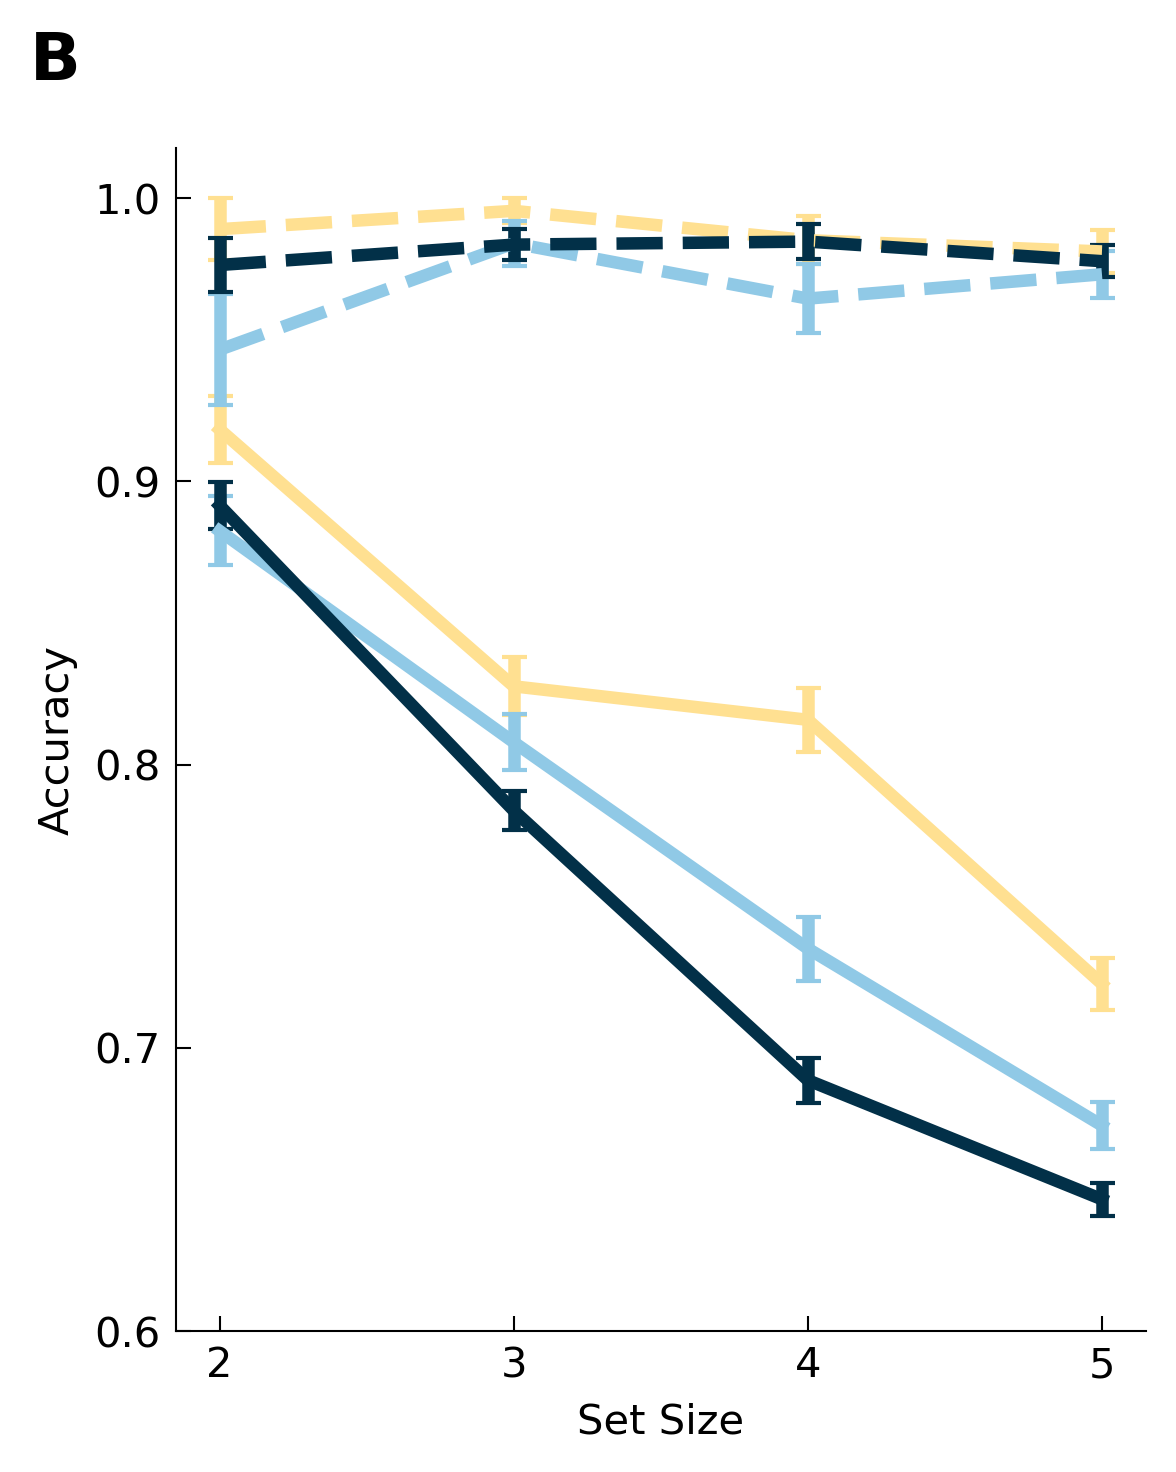

In [43]:
df_pd = pd.read_csv('clean_pd_mds_med.csv')
df_hc = pd.read_csv('clean_hc.csv')
colors = ['#ffb701', '#219ebc', '#023048']

# Filter invalid trials
df_pd = df_pd[(df_pd['learning'] != -1)]
df_hc = df_hc[(df_hc['learning'] != -1)]

# Define PD subgroups
df_under = df_pd[df_pd['med_motor_PAL'] < 2]
df_moderate = df_pd[df_pd['med_motor_PAL'] >= 2]

# Group
grouped_hc = df_hc.groupby(['learning', 'ns'])['correct'].agg(['mean', 'sem']).reset_index()
grouped_under = df_under.groupby(['learning', 'ns'])['correct'].agg(['mean', 'sem']).reset_index()
grouped_moderate = df_moderate.groupby(['learning', 'ns'])['correct'].agg(['mean', 'sem']).reset_index()

# Labels and styling
learning_labels = {0: 'Early Learning', 1: 'Late Learning'}
line_styles = {0: '-', 1: '--'}
group_data = {
    'HC': (grouped_hc, '#ffe091'),
    'PD Under': (grouped_under, '#90c9e6'),
    'PD OK': (grouped_moderate, '#023048')
}

# Plot
plt.figure(figsize=(4, 5))

for group_name, (group_df, color) in group_data.items():
    for learning_val in [0, 1]:
        subset = group_df[group_df['learning'] == learning_val]
        plt.errorbar(
            x=subset['ns'],
            y=subset['mean'],
            yerr=subset['sem'],
            linestyle=line_styles[learning_val],
            linewidth=3,
            capsize=3,
            color=color
        )

# Axis formatting
plt.xticks([2, 3, 4, 5], ['2', 3, 4, 5])
plt.xlabel('Set Size')
plt.ylabel('Accuracy')
plt.yticks(np.arange(0.6, 1.02, 0.1))

# Panel label
plt.text(-0.15, 1.1, 'B', transform=plt.gca().transAxes,
         fontsize=16, fontweight='bold', va='top', ha='left')
plt.tick_params(axis='both', direction='in')
ax = plt.gca()
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['left'].set_linewidth(0.5)
plt.tight_layout()
plt.show()


### Iterations on accuracy - behav

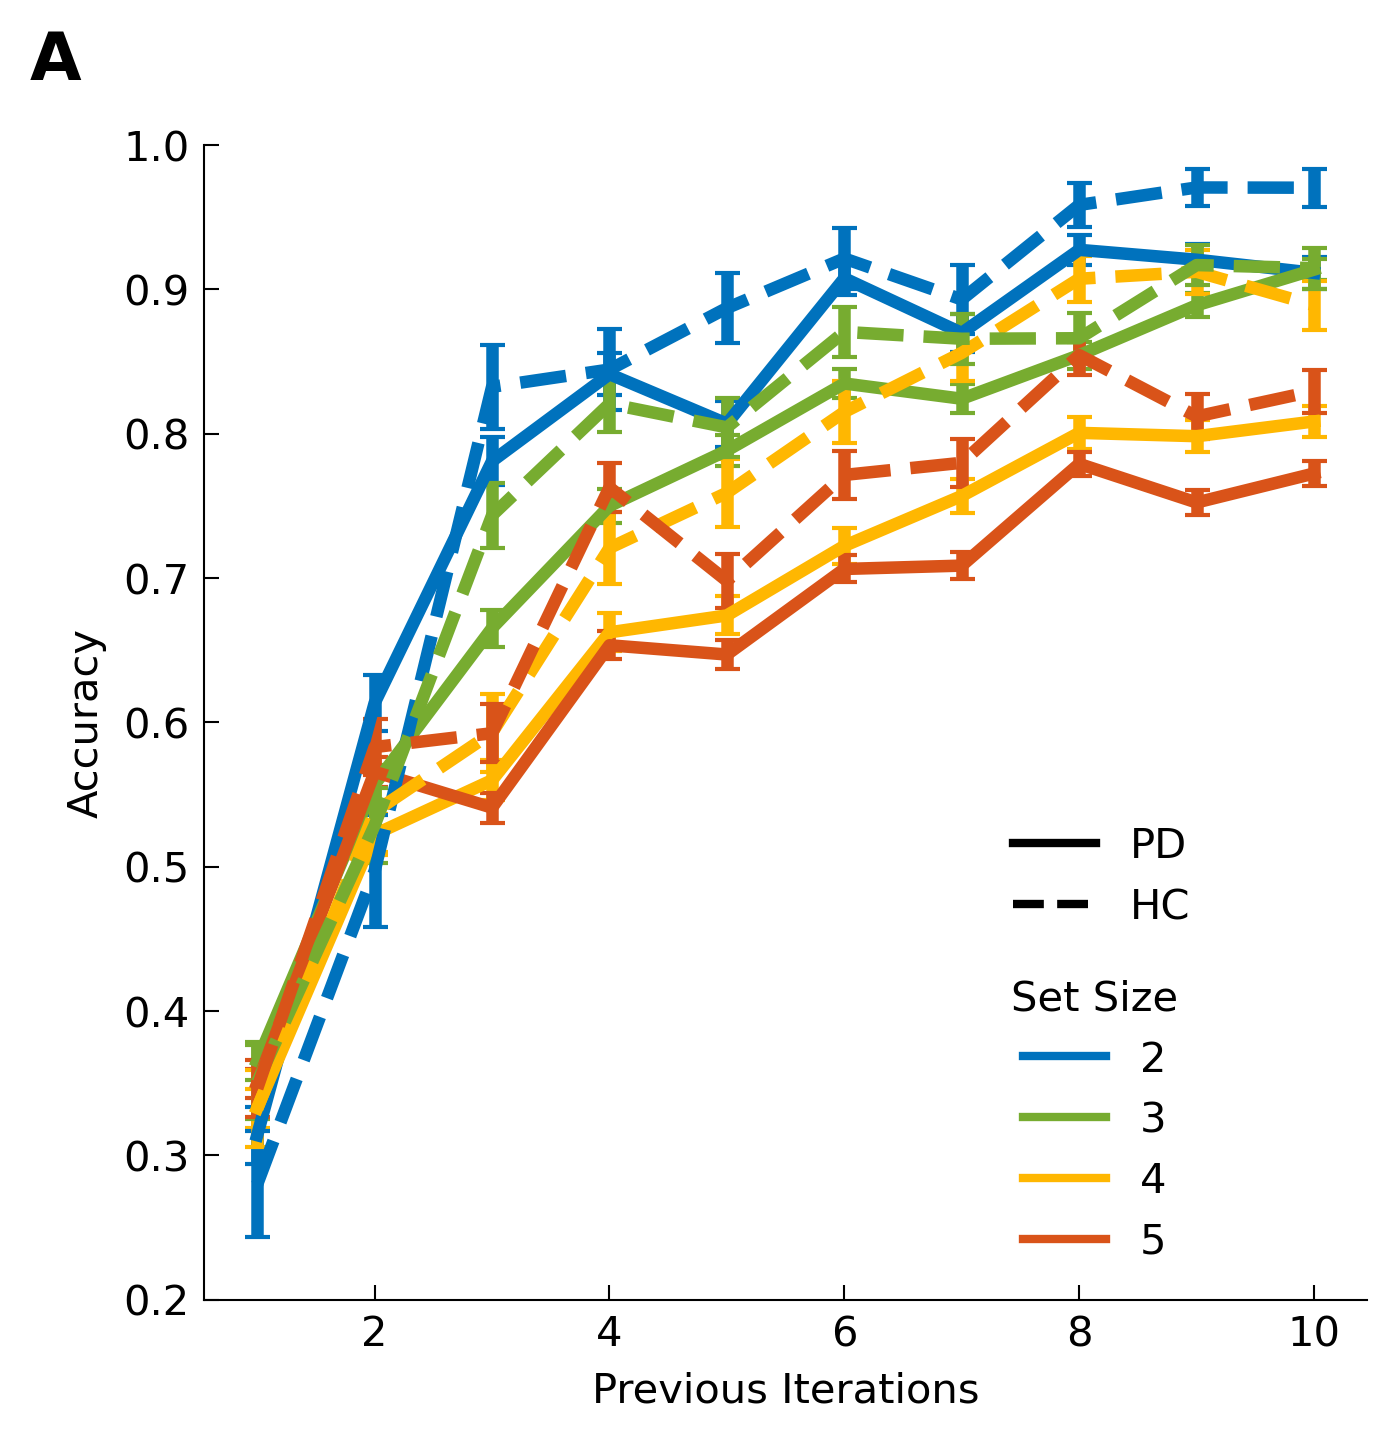

In [26]:
df_pd = pd.read_csv('clean_pd.csv')
df_hc = pd.read_csv('clean_hc.csv')

# Group and compute mean and SEM
grouped_pd = df_pd.groupby(['ns', 'iterseq'])['correct'].agg(['mean', 'sem']).reset_index()
grouped_hc = df_hc.groupby(['ns', 'iterseq'])['correct'].agg(['mean', 'sem']).reset_index()

plt.figure(figsize=(5, 5))

# Force ns order and remap colors
ns_order = [2, 4, 3, 5]
color_cycle = ["#0072bd", "#ffb701", "#77ac30", "#d95319"]
color_map = dict(zip(ns_order, color_cycle))
ns_values = ns_order  # override default sorting

# Plot PD data (solid lines)
for ns_value in ns_values:
    subset = grouped_pd[grouped_pd['ns'] == ns_value]
    plt.errorbar(
        x=subset['iterseq'],
        y=subset['mean'],
        yerr=subset['sem'],
        linestyle='-',
        color=color_map[ns_value],
        label=f'Set size = {ns_value}',
        markersize=4,
        linewidth=3,
        capsize=3
    )

# Plot HC data (dashed lines)
for ns_value in ns_values:
    subset = grouped_hc[grouped_hc['ns'] == ns_value]
    plt.errorbar(
        x=subset['iterseq'],
        y=subset['mean'],
        yerr=subset['sem'],
        linestyle='--',
        color=color_map[ns_value],
        markersize=4,
        linewidth=3,
        capsize=3
    )

# Remove top and right spines (APA style)
for spine in ['top', 'right']:
    plt.gca().spines[spine].set_visible(False)

plt.xlabel('Previous Iterations')
plt.ylabel('Accuracy')
plt.ylim(0.2, 1)

# Legend for set size (color only)
legend_order = sorted(ns_values)  # [2, 3, 4, 5]

main_legend = plt.legend(
    handles=[Line2D([0], [0], color=color_map[ns], lw=2, label=f'{ns}') for ns in legend_order],
    loc='lower right',
    bbox_to_anchor=(0.87, 0),
    frameon=False,
    title='Set Size'
)

line_legend = plt.legend(
    handles=[
        Line2D([0], [0], color='black', lw=2, linestyle='-', label='PD'),
        Line2D([0], [0], color='black', lw=2, linestyle='--', label='HC')
    ],
    loc='lower right',
    bbox_to_anchor=(0.88, 0.29),  # (x, y): y=0 is very bottom, 1 is top
    frameon=False
)

# Add the main legend back
plt.gca().add_artist(main_legend)

plt.text(-0.15, 1.1, 'A', transform=plt.gca().transAxes,
         fontsize=16, fontweight='bold', va='top', ha='left')
plt.tick_params(axis='both', direction='in')
ax = plt.gca()
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['left'].set_linewidth(0.5)
plt.show()

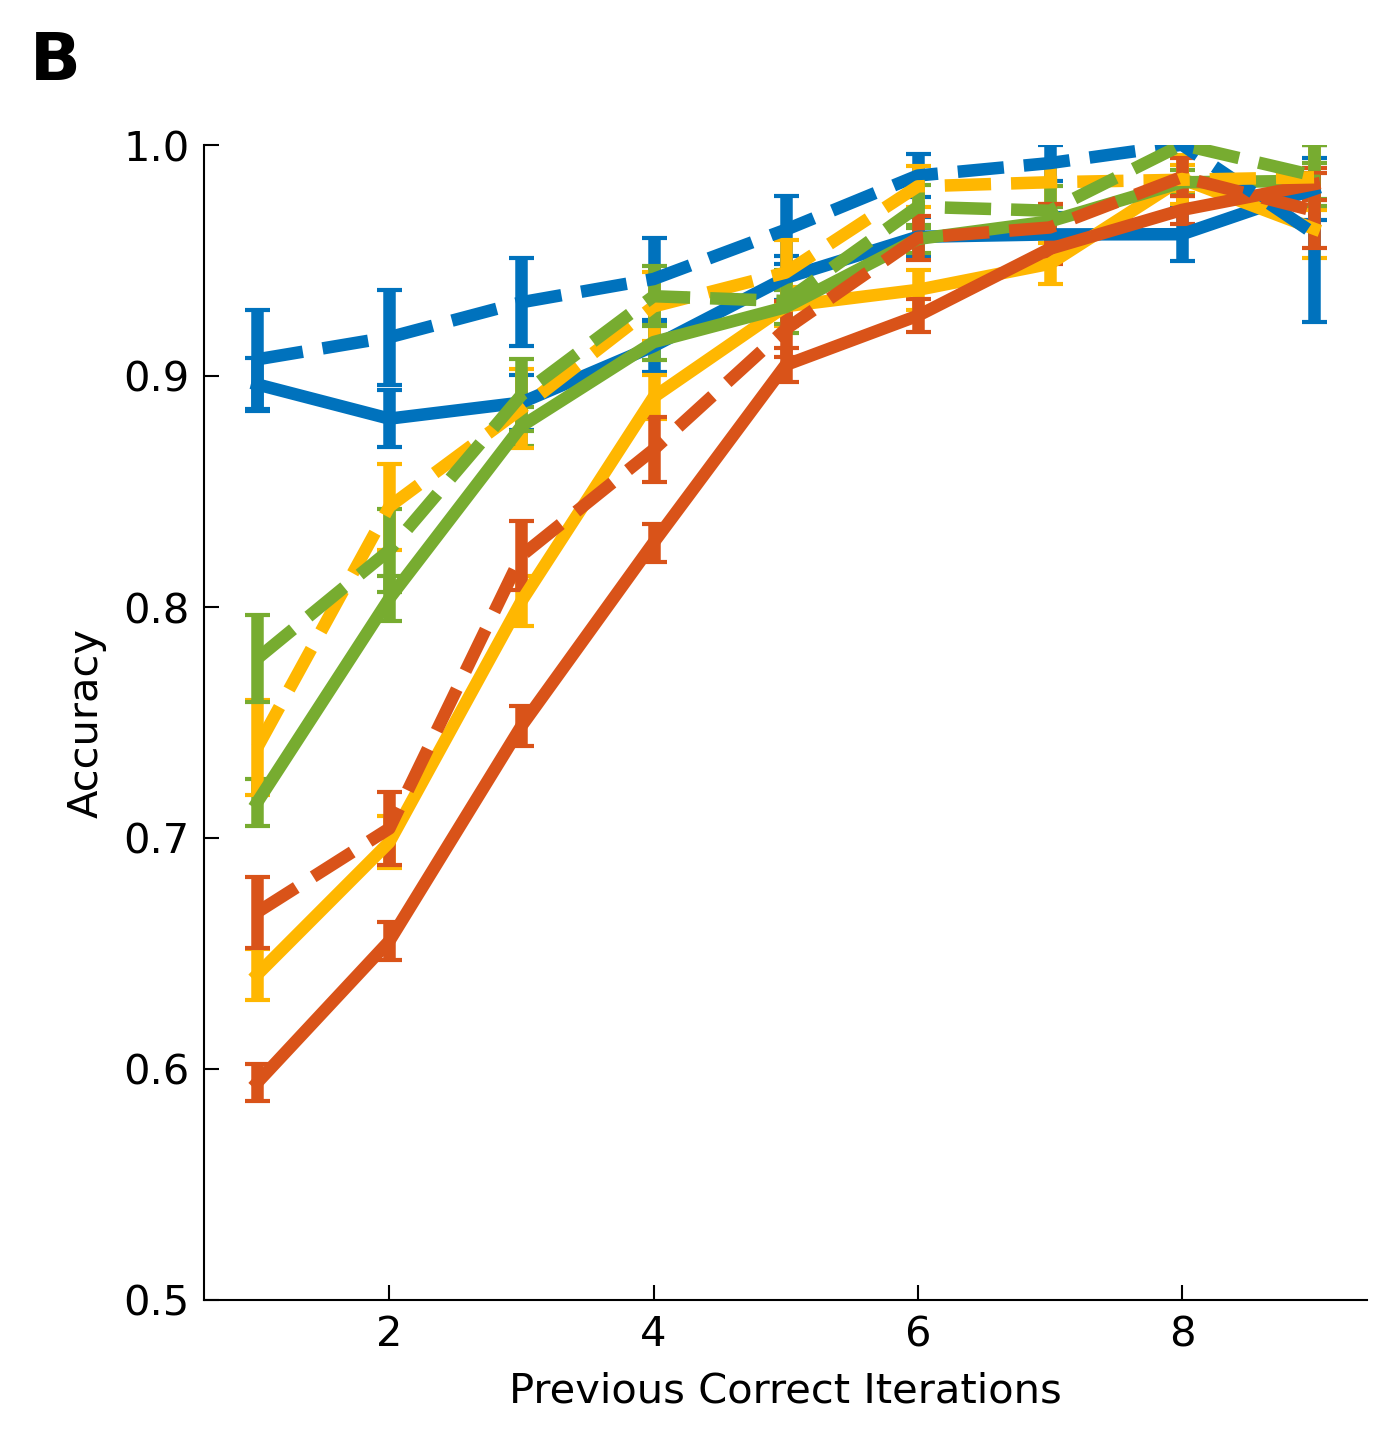

In [18]:
df_pd = pd.read_csv('clean_pd.csv')
df_hc = pd.read_csv('clean_hc.csv') 

df_pd = df_pd[df_pd['pcor'] != 0]
df_hc = df_hc[df_hc['pcor'] != 0]

# Group and compute mean + sem
grouped_pd = df_pd.groupby(['ns', 'pcor'])['correct'].agg(['mean', 'sem']).reset_index()
grouped_hc = df_hc.groupby(['ns', 'pcor'])['correct'].agg(['mean', 'sem']).reset_index()

plt.figure(figsize=(5, 5))

# Force ns order and remap colors
ns_order = [2, 4, 3, 5]
color_cycle = ["#0072bd", "#ffb701", "#77ac30", "#d95319"]
color_map = dict(zip(ns_order, color_cycle))
ns_values = ns_order  # override default sorting

# Plot PD data (solid lines)
for ns_value in ns_values:
    subset = grouped_pd[grouped_pd['ns'] == ns_value]
    plt.errorbar(
        x=subset['pcor'],
        y=subset['mean'],
        yerr=subset['sem'],
        linestyle='-',
        linewidth=3,
        label=f'Set size = {ns_value}',
        capsize=3,
        color=color_map[ns_value]
    )

# Plot HC data (dashed lines)
for ns_value in ns_values:
    subset = grouped_hc[grouped_hc['ns'] == ns_value]
    plt.errorbar(
        x=subset['pcor'],
        y=subset['mean'],
        yerr=subset['sem'],
        linestyle='--',
        linewidth=3,
        capsize=3,
        color=color_map[ns_value]
    )

# Axis labels and ticks
plt.xlabel('Previous Correct Iterations')
plt.ylabel('Accuracy')
plt.xticks([2, 4, 6, 8])
plt.ylim(0.5, 1)

plt.text(-0.15, 1.1, 'B', transform=plt.gca().transAxes,
         fontsize=16, fontweight='bold', va='top', ha='left')
plt.tick_params(axis='both', direction='in')
ax = plt.gca()
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['left'].set_linewidth(0.5)
plt.show()

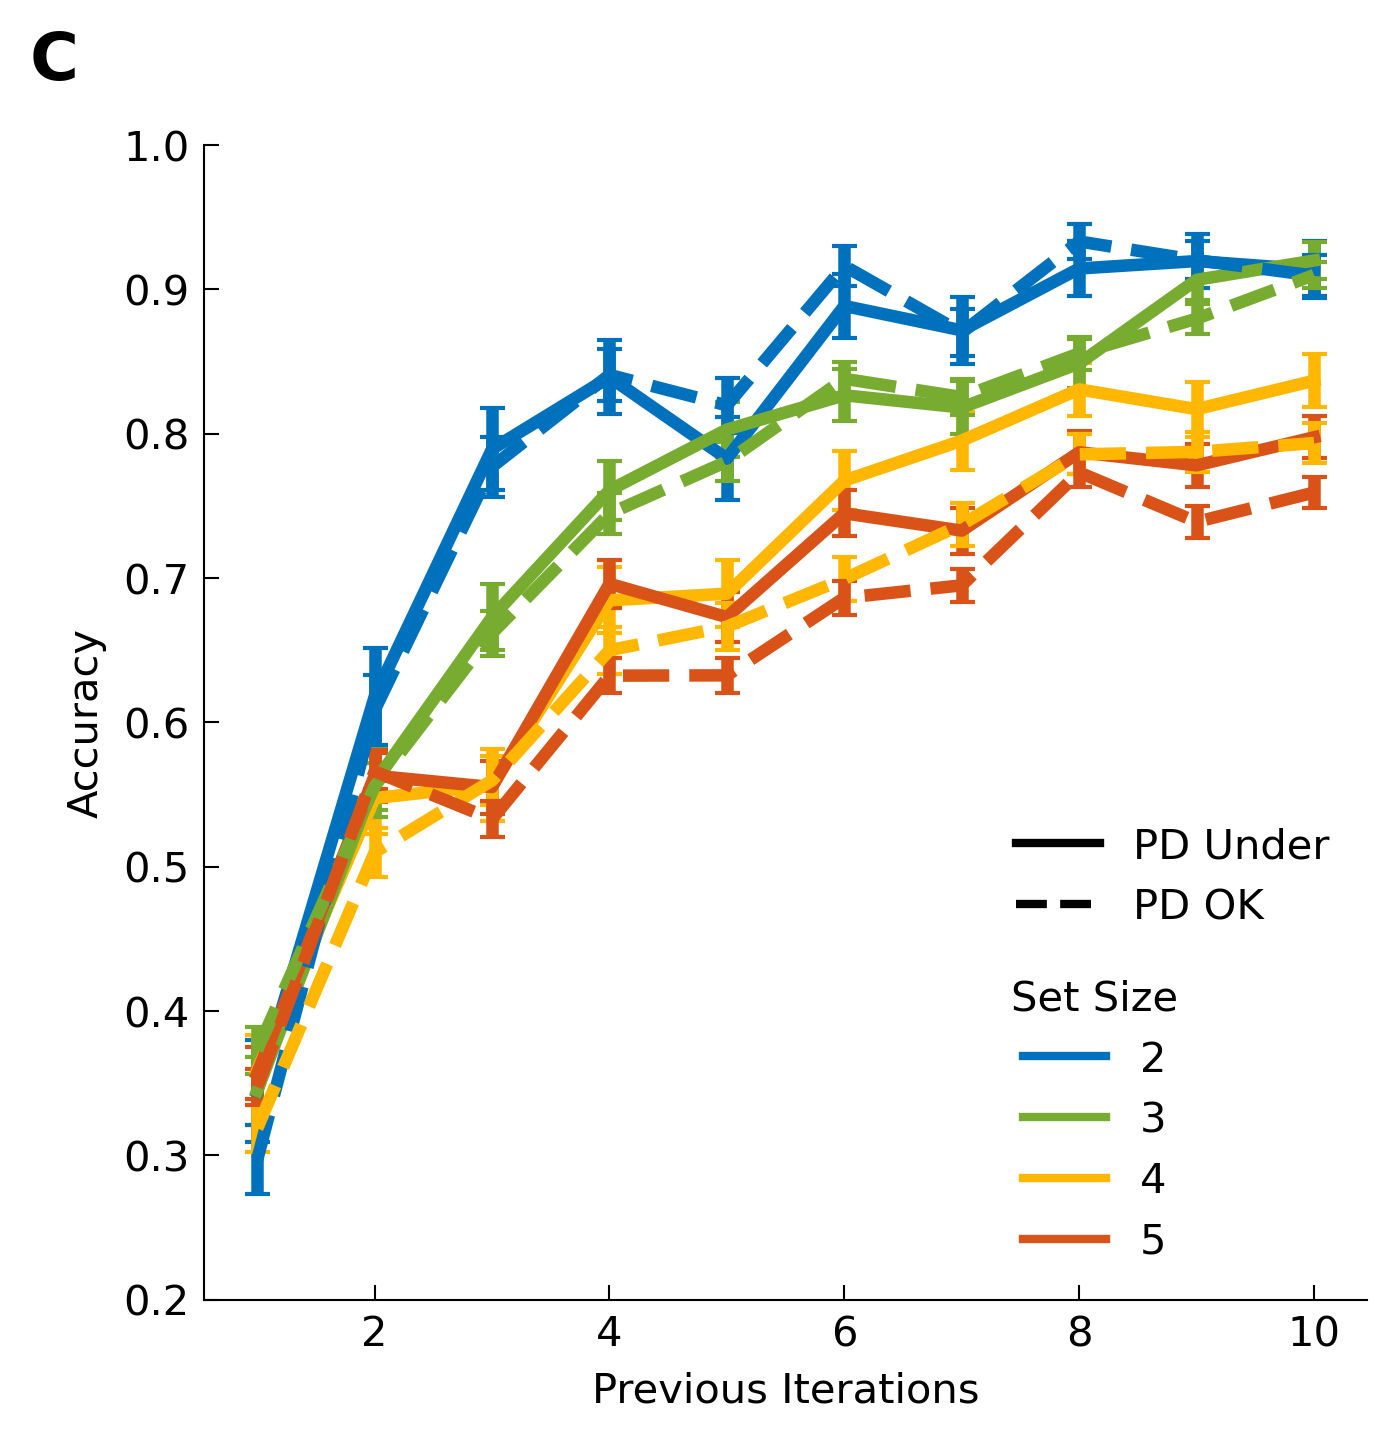

In [24]:
df_pd = pd.read_csv('clean_pd_mds_med.csv')
df_high = df_pd[df_pd['med_motor_PAL'] >= 2]
df_low = df_pd[df_pd['med_motor_PAL'] < 2]

# Group and compute mean and SEM
grouped_low = df_low.groupby(['ns', 'iterseq'])['correct'].agg(['mean', 'sem']).reset_index()
grouped_high = df_high.groupby(['ns', 'iterseq'])['correct'].agg(['mean', 'sem']).reset_index()

plt.figure(figsize=(5, 5))

# Force ns order and remap colors
ns_order = [2, 4, 3, 5]
color_cycle = ["#0072bd", "#ffb701", "#77ac30", "#d95319"]
color_map = dict(zip(ns_order, color_cycle))
ns_values = ns_order  # override default sorting

# Plot PD data (solid lines)
for ns_value in ns_values:
    subset = grouped_low[grouped_low['ns'] == ns_value]
    plt.errorbar(
        x=subset['iterseq'],
        y=subset['mean'],
        yerr=subset['sem'],
        linestyle='-',
        color=color_map[ns_value],
        label=f'Set size = {ns_value}',
        markersize=4,
        linewidth=3,
        capsize=3
    )

# Plot HC data (dashed lines)
for ns_value in ns_values:
    subset = grouped_high[grouped_high['ns'] == ns_value]
    plt.errorbar(
        x=subset['iterseq'],
        y=subset['mean'],
        yerr=subset['sem'],
        linestyle='--',
        color=color_map[ns_value],
        markersize=4,
        linewidth=3,
        capsize=3
    )

# Remove top and right spines (APA style)
for spine in ['top', 'right']:
    plt.gca().spines[spine].set_visible(False)

plt.xlabel('Previous Iterations')
plt.ylabel('Accuracy')
plt.ylim(0.2, 1)

# Legend for set size (color only)
legend_order = sorted(ns_values)  # [2, 3, 4, 5]

main_legend = plt.legend(
    handles=[Line2D([0], [0], color=color_map[ns], lw=2, label=f'{ns}') for ns in legend_order],
    loc='lower right',
    bbox_to_anchor=(0.87, 0),
    frameon=False,
    title='Set Size'
)

line_legend = plt.legend(
    handles=[
        Line2D([0], [0], color='black', lw=2, linestyle='-', label='PD Under'),
        Line2D([0], [0], color='black', lw=2, linestyle='--', label='PD OK')
    ],
    loc='lower right',
    bbox_to_anchor=(1, 0.29),  # (x, y): y=0 is very bottom, 1 is top
    frameon=False
)

# Add the main legend back
plt.gca().add_artist(main_legend)

plt.text(-0.15, 1.1, 'C', transform=plt.gca().transAxes,
         fontsize=16, fontweight='bold', va='top', ha='left')
plt.tick_params(axis='both', direction='in')
ax = plt.gca()
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['left'].set_linewidth(0.5)
plt.show()

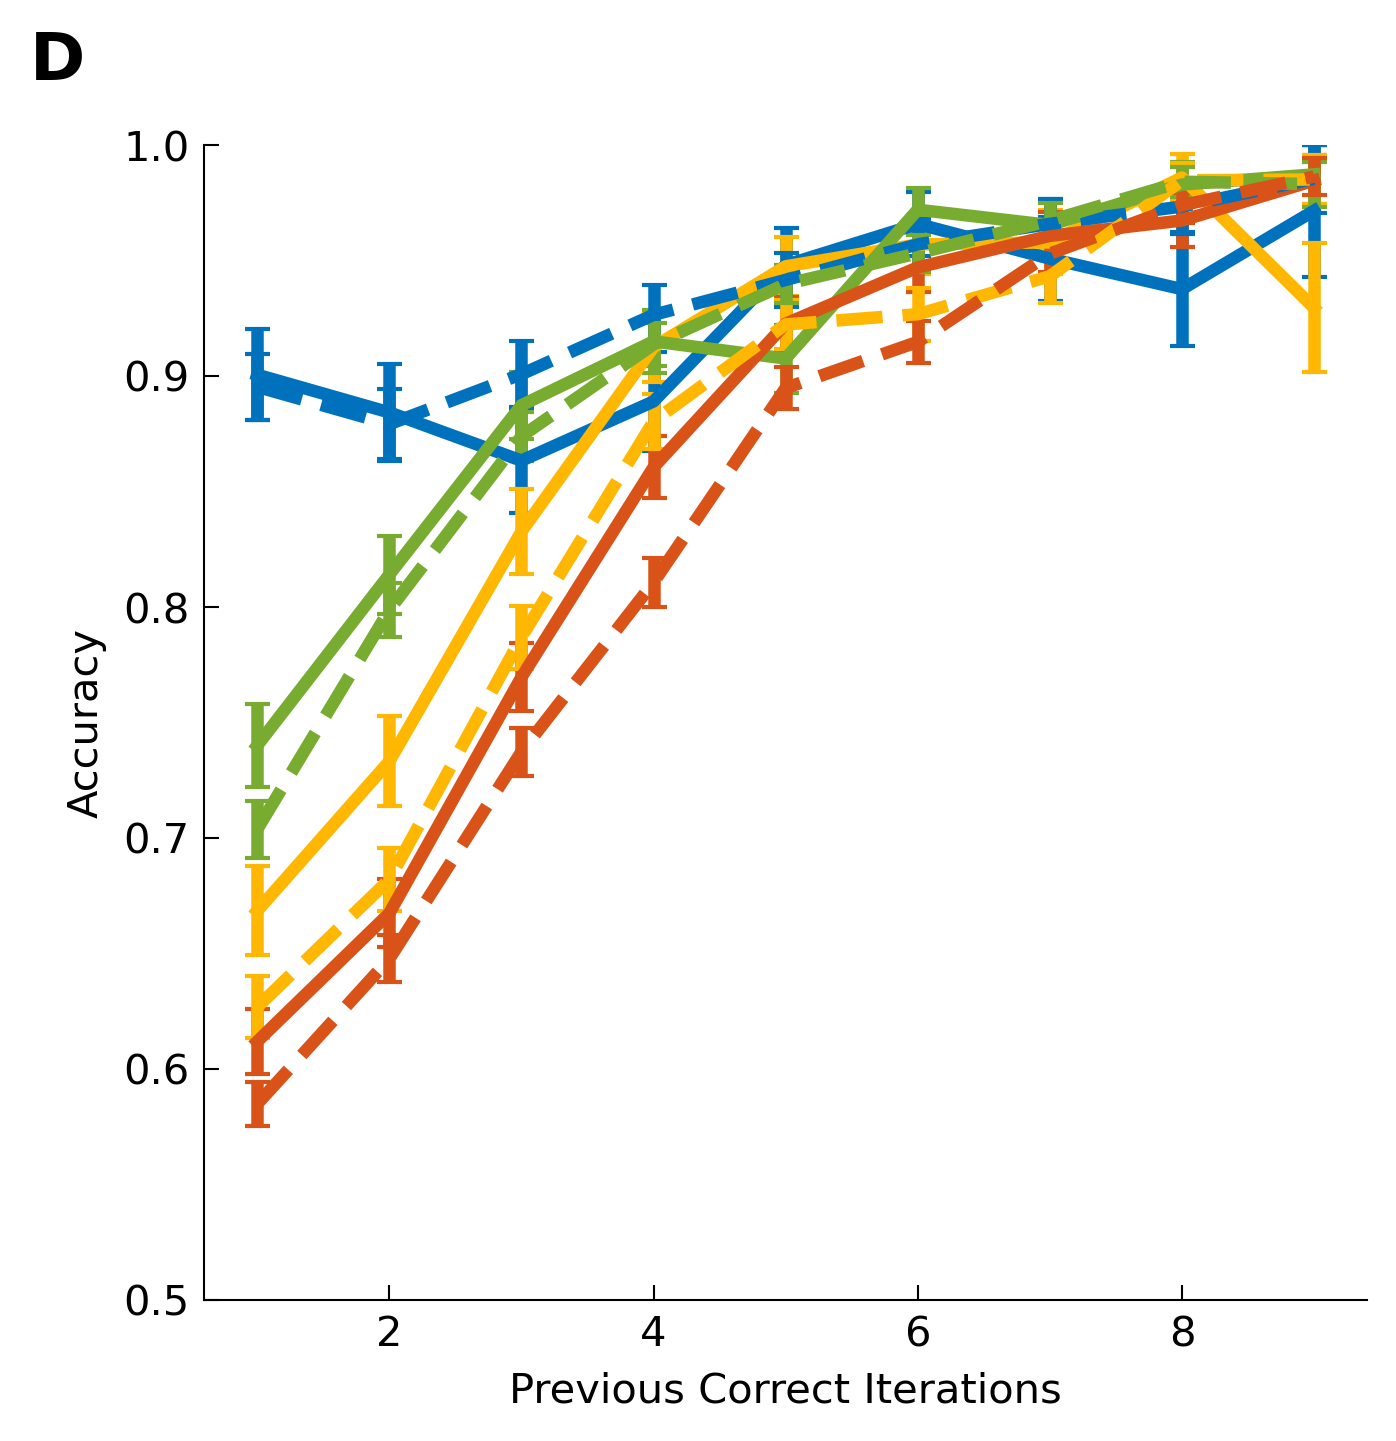

In [20]:
df_pd = pd.read_csv('clean_pd_mds_med.csv')
df_pd = df_pd[df_pd['pcor'] != 0]

df_high = df_pd[df_pd['med_motor_PAL'] >= 2]
df_low = df_pd[df_pd['med_motor_PAL'] < 2]

# Group and compute mean and SEM
grouped_low = df_low.groupby(['ns', 'pcor'])['correct'].agg(['mean', 'sem']).reset_index()
grouped_high = df_high.groupby(['ns', 'pcor'])['correct'].agg(['mean', 'sem']).reset_index()

plt.figure(figsize=(5, 5))

# Force ns order and remap colors
ns_order = [2, 4, 3, 5]
color_cycle = ["#0072bd", "#ffb701", "#77ac30", "#d95319"]
color_map = dict(zip(ns_order, color_cycle))
ns_values = ns_order  # override default sorting

# Plot PD data (solid lines)
for ns_value in ns_values:
    subset = grouped_low[grouped_low['ns'] == ns_value]
    plt.errorbar(
        x=subset['pcor'],
        y=subset['mean'],
        yerr=subset['sem'],
        linestyle='-',
        color=color_map[ns_value],
        label=f'Set size = {ns_value}',
        markersize=4,
        linewidth=3,
        capsize=3
    )

# Plot HC data (dashed lines)
for ns_value in ns_values:
    subset = grouped_high[grouped_high['ns'] == ns_value]
    plt.errorbar(
        x=subset['pcor'],
        y=subset['mean'],
        yerr=subset['sem'],
        linestyle='--',
        color=color_map[ns_value],
        markersize=4,
        linewidth=3,
        capsize=3
    )

# Remove top and right spines (APA style)
for spine in ['top', 'right']:
    plt.gca().spines[spine].set_visible(False)

# Axis labels and ticks
plt.xlabel('Previous Correct Iterations')
plt.ylabel('Accuracy')
plt.xticks([2, 4, 6, 8])
plt.ylim(0.5, 1)

plt.text(-0.15, 1.1, 'D', transform=plt.gca().transAxes,
         fontsize=16, fontweight='bold', va='top', ha='left')
plt.tick_params(axis='both', direction='in')
ax = plt.gca()
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['left'].set_linewidth(0.5)
plt.show()

### Accuracy difference

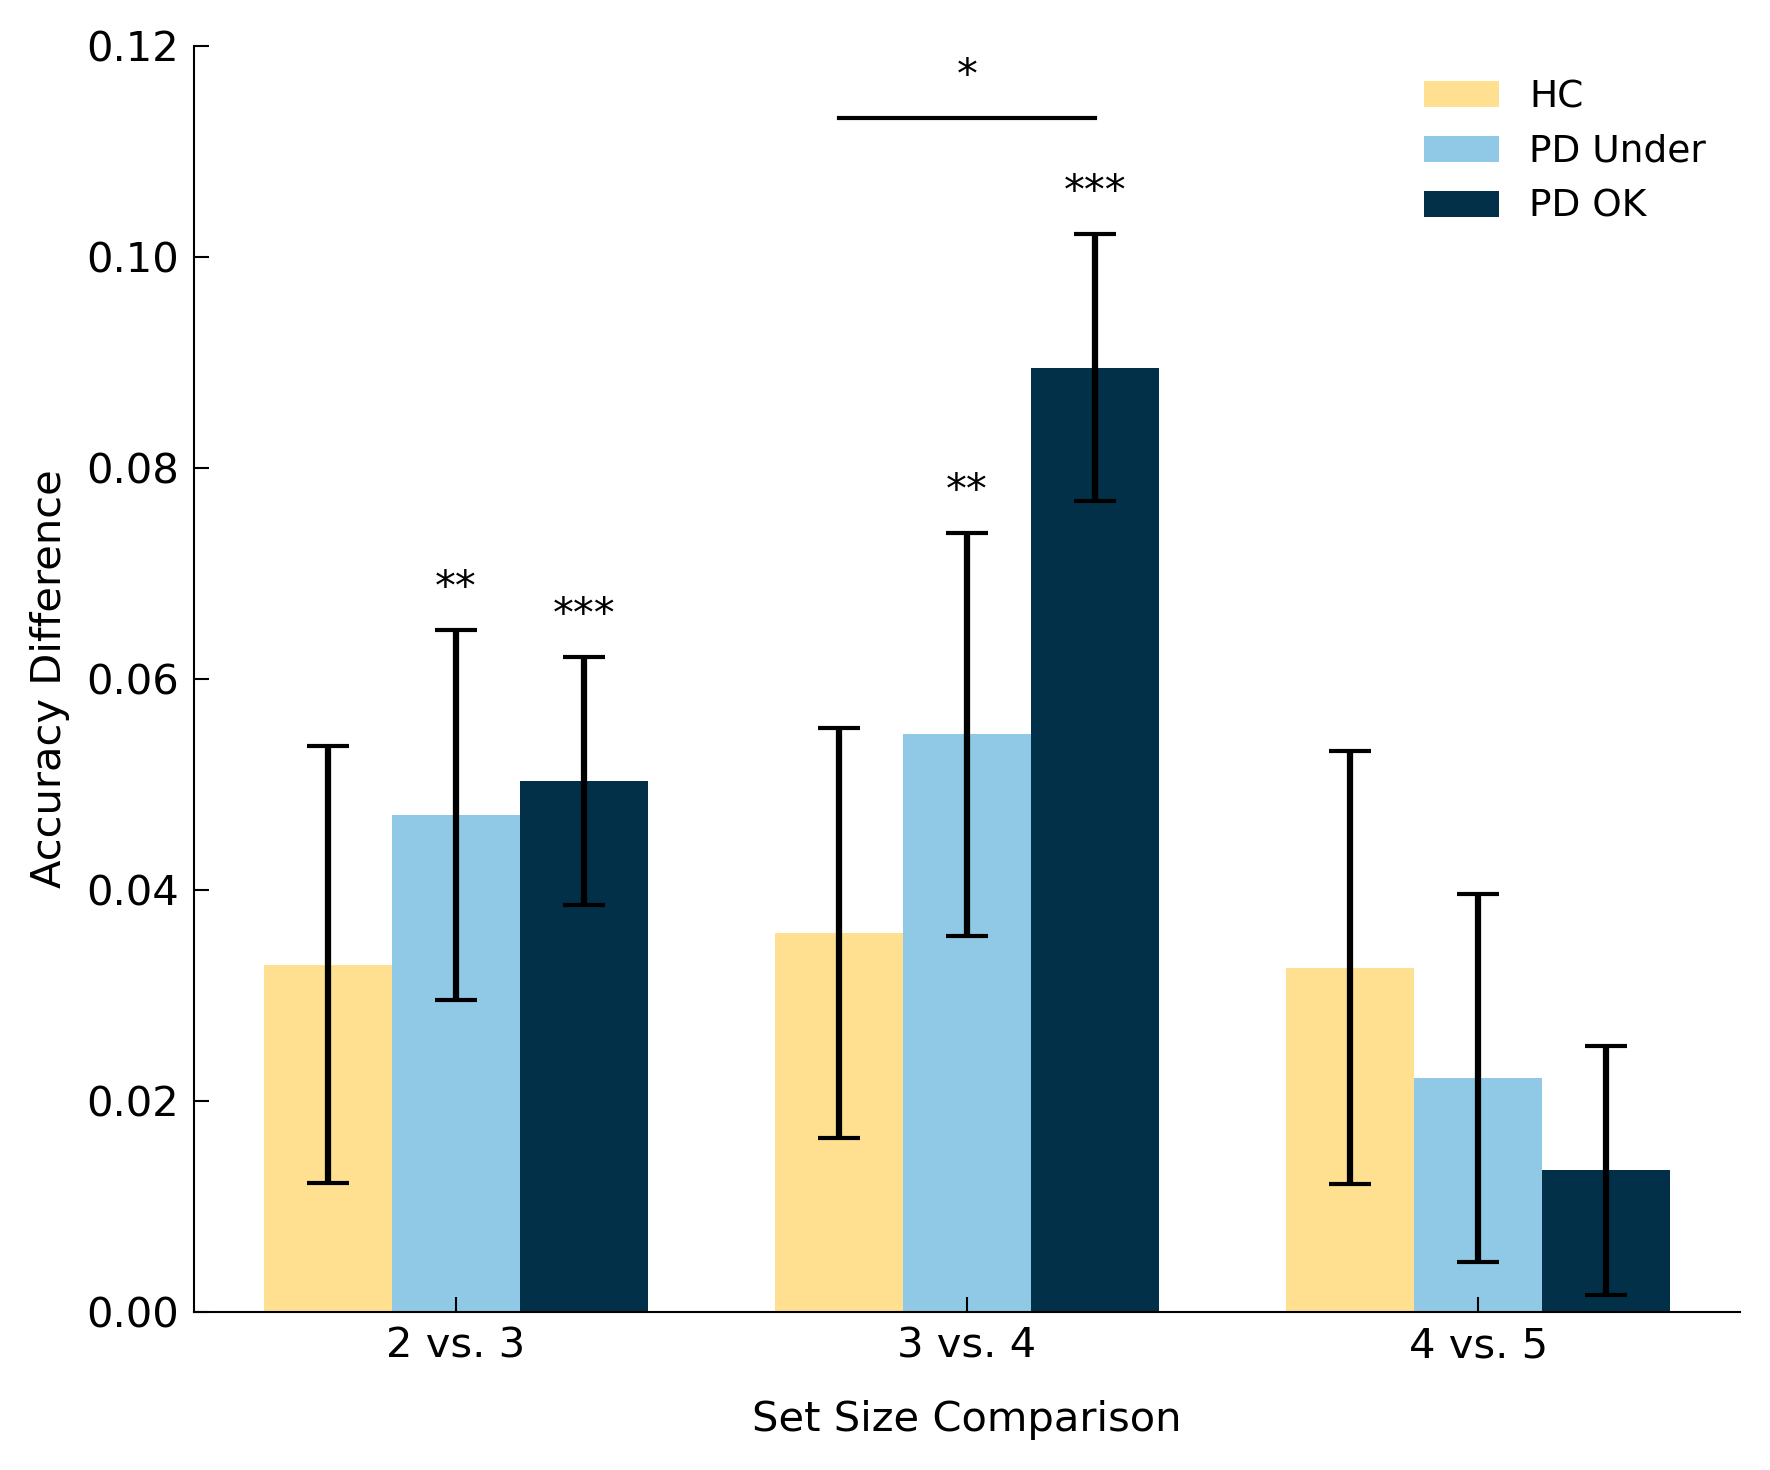

In [72]:
df_pd = pd.read_csv('clean_pd_mds_med.csv')
df_hc = pd.read_csv('clean_hc.csv')

# Define subgroups
df_under = df_pd[df_pd['med_motor_PAL'] < 2]
df_moderate = df_pd[df_pd['med_motor_PAL'] >= 2]

# Function to compute accuracy difference
def compute_accuracy_diff(df):
    acc = df.groupby(['subno', 'ns'])['correct'].mean().unstack()
    acc_diff = pd.DataFrame({
        '2-3': acc[2] - acc[3],
        '3-4': acc[3] - acc[4],
        '4-5': acc[4] - acc[5]
    })
    return acc_diff

# Compute group diffs
hc_diff = compute_accuracy_diff(df_hc)
under_diff = compute_accuracy_diff(df_under)
moderate_diff = compute_accuracy_diff(df_moderate)

group_names = ['HC', 'PD Under', 'PD OK']
group_diffs = [hc_diff, under_diff, moderate_diff]
colors = ['#ffe091', '#90c9e6', '#023048']

labels = ['2 vs. 3', '3 vs. 4', '4 vs. 5']
x = np.arange(len(labels)) * 0.8
width = 0.2

means, sems = [], []
for diff in group_diffs:
    means.append([diff[c].mean() for c in ['2-3', '3-4', '4-5']])
    sems.append([diff[c].sem() for c in ['2-3', '3-4', '4-5']])

# Plot
fig, ax = plt.subplots(figsize=(6, 5))

bars = []
for i, (mean_vals, sem_vals, color) in enumerate(zip(means, sems, colors)):
    pos = x + (i - 1) * width  # Center bars: HC = -width, Under = 0, Moderate = +width
    bars.append(ax.bar(pos, mean_vals, width, yerr=sem_vals,
                       color=color, label=group_names[i], capsize=5, linewidth=1.5))

# One-sample t-tests vs 0
for i, diff in enumerate(group_diffs):
    for j, label in enumerate(['2-3', '3-4', '4-5']):
        values = diff[label].dropna()
        t_stat, p = ttest_1samp(values, 0)
        if p < 0.001: sig = '***'
        elif p < 0.01: sig = '**'
        elif p < 0.05: sig = '*'
        else: sig = ''
        if sig:
            bar_x = x[j] + (i - 1) * width
            y = values.mean() + values.sem() + 0.002
            ax.text(bar_x, y, sig, ha='center', va='bottom', fontsize=10)

# Between-group comparisons: Moderate vs HC
for j, label in enumerate(['2-3', '3-4', '4-5']):
    p_val = ttest_ind(moderate_diff[label].dropna(), hc_diff[label].dropna()).pvalue
    if p_val < 0.001: sig = '***'
    elif p_val < 0.01: sig = '**'
    elif p_val < 0.05: sig = '*'
    else: sig = ''
    if sig:
        # Positions: HC = -width, Moderate = +width
        pos1 = x[j] - width
        pos2 = x[j] + width
        y1 = means[0][j] + sems[0][j]
        y2 = means[2][j] + sems[2][j]
        y_max = max(y1, y2) + 0.011
        ax.plot([pos1, pos2], [y_max, y_max], color='black', linewidth=1)
        ax.text(x[j], y_max + 0.002, sig, ha='center', va='bottom', fontsize=10)

# Axis and aesthetics
ax.set_ylabel('Accuracy Difference')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_xlabel('Set Size Comparison', labelpad=8)
ax.set_ylim(bottom=0, top=0.12)

ax.legend(loc='upper right', fontsize=9, frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', direction='in')
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['left'].set_linewidth(0.5)

plt.tight_layout()
plt.show()


### Random

set size * delay

In [ ]:
# Remove trials where delays are -1
df_2 = df[df['delay'] != -1]
# All values higher than n in "delay_corr" are integrated into the same group
df_2['delay_grp'] = np.where(df_2['delay'] >= 5, '5+', df_2['delay'])
# Calculate the average accuracy
grouped = df_2.groupby(['ns', 'delay_grp'])['correct'].agg(['mean', 'sem']).reset_index()

# Plot
plt.figure(figsize=(6, 6))
for i, ns_value in enumerate(grouped['ns'].unique()):
    subset = grouped[grouped['ns'] == ns_value]
    errorbar_plot = plt.errorbar(
        x=subset['delay_grp'],
        y=subset['mean'],
        yerr=subset['sem'],
        marker='o',
        linestyle='-',
        linewidth=2,
        markersize=4,
        label=f'Set size = {ns_value}',
        capsize=3
    )

# Remove top and right spines (APA style)
for spine in ['top', 'right']:
    plt.gca().spines[spine].set_visible(False)
plt.legend(fontsize=12, loc='lower right', frameon=False)
plt.xlabel('Delay since last correct trial', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0.4, 1.02)
plt.show()

Speed-accuracy trade-off

In [ ]:
conditions = [
    (0, None), (1, None),  # Overall
    (0, 1), (1, 1),        # Learning 1
    (0, 3), (1, 3)         # Learning 3
]

# Generate data series
rts = [
    df[(df['correct'] == c) & (df['learning'] == l if l else df['correct'] == c)]['rt']
    for c, l in conditions
]

# Calculate means and SEMs
means = [rt.mean() for rt in rts]
ses = [rt.sem() for rt in rts]

# Visualization parameters
bar_width = 0.2
x_pos = [0.4, 0.6, 0.9, 1.1, 1.4, 1.6]  # Three groups
colors = ['#1f77b4', '#7ec8e3'] * 3     # Alternate colors for incorrect/correct
group_labels = ['All trials', 'Early learning', 'Late learning']
xticks_pos = [0.5, 1.0, 1.5]            # Group label centers

plt.figure(figsize=(10, 8))

# Create bars with error caps
bars = plt.bar(x_pos, means, width=bar_width,
               yerr=ses, capsize=7, color=colors, 
               edgecolor='none')

# Set up axes
plt.xticks(xticks_pos, group_labels, fontsize=14)
plt.ylabel('Reaction time (ms)', fontsize=14)
plt.ylim(0, max(means) * 1.5)
plt.yticks(fontsize=14)
plt.gca().spines[['top', 'right']].set_visible(False)

# Statistical annotations
groups = [(0,1), (2,3), (4,5)]  # Bar indices for each group
for idx, (i,j) in enumerate(groups):
    t_stat, p = stats.ttest_ind(rts[i], rts[j], equal_var=False)
    
    # Determine significance stars
    if p < 0.001:
        stars = '***'
    elif p < 0.01:
        stars = '**'
    elif p < 0.05:
        stars = '*'
    else:
        stars = 'ns'
    
    # Calculate annotation position
    y_base = max(means[i] + ses[i], means[j] + ses[j])
    line_y = y_base * 1.1
    text_y = line_y * 1.05
    
    # Draw significance markers
    plt.plot([x_pos[i], x_pos[j]], [line_y]*2, '-', color='k', lw=1)
    plt.text(np.mean([x_pos[i], x_pos[j]]), text_y, 
             f'{stars}\n$p$ = {p:.3f}', 
             ha='center', va='bottom', fontsize=12)

# Create simplified legend
legend_elements = [
    plt.Rectangle((0,0),1,1, color='#1f77b4', label='Incorrect'),
    plt.Rectangle((0,0),1,1, color='#7ec8e3', label='Correct')
]
plt.legend(handles=legend_elements,
           frameon=False,
           bbox_to_anchor=(1, 0.9),
           fontsize=14)

plt.tight_layout()
plt.show()